In [35]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams['figure.dpi'] = 100
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import numpy as np
import pandas as pd
import pickle

import os
import requests
from io import BytesIO
from io import StringIO

from astropy.table import Table
from astropy.table import join
from astropy.io import ascii
import astropy.constants as c

from sklearn import svm
#from arviz import hpd

# Function to get NASA Exoplanet Archive catalogs 
# from Dan Foreman-Mackey (https://github.com/dfm/exopop)
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

#To track the provenance of different columns, we want a function to prepend an informative string to each column name.
#We will do this before merging tables to make tracking the information easier.
def prepend_dataframe_columns(df, prefix):
    df.columns = [prefix+col for col in df.columns]
    return 

### CKS VII Sample (Fulton & Petigura 2018)
As a starting point we will begin with the CKS VII sample. This includes some planets which were not contained in Kepler Q1-Q17 DR25, so it allows us to study a larger sample.

In [2]:
#data_dir = "../data/"
data_dir = "/Users/tdavid/Dropbox (Simons Foundation)/multis/data/"

cks_st = Table.read(data_dir+"Fulton2018_stellarradii_ajaae828t2_mrt.txt", format='ascii')
cks_pl = Table.read(data_dir+"Fulton2018_planetradii_ajaae828t3_mrt.txt", format='ascii')

# In order to join the tables we need to reformat the KOI identifiers
cks_pl['KOI_star'] = np.array([(x.split(".")[0]) for x in cks_pl['KOI']])
cks_st.rename_column('KOI', 'KOI_star')

# Join the CKS tables
cks = join(cks_pl, cks_st, join_type='left', keys='KOI_star')
# Prepend a prefix to each column to help keep track of the provenance of the data
cks = cks.to_pandas()
#cks.columns = ["f18_"+col for col in cks.columns] 
prepend_dataframe_columns(cks, 'f18_')
cks.head(5)

,f18_KOI,f18_P,f18_E_P,f18_e_P,f18_Rp/R*,f18_E_Rp/R*,f18_e_Rp/R*,f18_Rp,f18_E_Rp,f18_e_Rp,...,f18_E_rhoiso,f18_e_rhoiso,f18_logAiso,f18_E_logAiso,f18_e_logAiso,f18_plxspec,f18_E_plxspec,f18_e_plxspec,f18_r8,f18_RCF
0,K00001.01,2.470613,1.900000e-08,1.900000e-08,0.123851,0.000025,0.000076,14.141,0.331,0.331,...,0.04,0.04,9.74,0.13,0.15,4.756,0.320,0.474,1.000,1.0102
1,K00002.01,2.204735,3.800000e-08,3.800000e-08,0.075408,0.000008,0.000007,16.250,0.349,0.349,...,0.01,0.00,9.25,0.04,0.05,3.661,0.411,0.586,1.001,1.0034
2,K00006.01,1.334104,7.070000e-07,7.070000e-07,0.294016,0.103683,0.209459,41.936,22.239,22.239,...,0.03,0.03,9.32,0.09,0.24,2.201,0.127,0.212,1.007,1.0006
3,K00007.01,3.213669,1.122000e-06,1.122000e-06,0.024735,0.000141,0.000076,4.076,0.107,0.107,...,0.02,0.02,9.78,0.09,0.08,2.112,0.228,0.274,1.000,NaN
4,K00008.01,1.160153,4.270000e-07,4.270000e-07,0.018559,0.000246,0.001678,1.896,0.110,0.110,...,0.03,0.05,9.18,0.26,0.52,2.895,0.127,0.192,1.001,NaN


### CKS I (Petigura et al. 2017)
For consistency with CKS VII, we will use the false positive designations adopted in Table 4 of CKS I, which themselves are based on a compilation of planet candidate dispositions from Morton et al. (2016), Mullaly et al. (2015), and the NASA Exoplanet Archive (as it was on Feb. 1, 2017).

In [3]:
p17 = Table.read('http://cdsarc.unistra.fr/ftp/J/AJ/154/107/table4.dat',
                 readme='http://cdsarc.unistra.fr/ftp/J/AJ/154/107/ReadMe',
                 format='ascii.cds')

p17 = p17.to_pandas()
#Munging
p17['Name'] = [x.replace('OI-', '') for x in p17['Name']]
p17 = p17.rename(columns={'Name':'KOI'})
prepend_dataframe_columns(p17, 'p17_')

p17.head()

,p17_KOI,p17_Disp,p17_M16,p17_M15,p17_NEA
0,K00001.01,CP,CP,CP,CP
1,K00002.01,CP,CP,CP,CP
2,K00003.01,CP,CP,CP,CP
3,K00006.01,FP,FP,FP,FP
4,K00007.01,CP,CP,CP,CP


### Kepler Q1-Q17 DR25 table
As a starting point we begin with the [Kepler Q1-Q17 DR 25 KOI Table](https://exoplanetarchive.ipac.caltech.edu/docs/PurposeOfKOITable.html#q1-q17_dr25) which is described in [Thompson et al. 2018](https://arxiv.org/abs/1710.06758)

In [4]:
dr25 = get_catalog('q1_q17_dr25_koi')
prepend_dataframe_columns(dr25, 'dr25_')
dr25.head()

,dr25_kepid,dr25_kepoi_name,dr25_kepler_name,dr25_ra,dr25_ra_err,dr25_ra_str,dr25_dec,dr25_dec_err,dr25_dec_str,dr25_koi_gmag,...,dr25_koi_fpflag_co,dr25_koi_fpflag_ec,dr25_koi_insol,dr25_koi_insol_err1,dr25_koi_insol_err2,dr25_koi_srho,dr25_koi_srho_err1,dr25_koi_srho_err2,dr25_koi_fittype,dr25_koi_score
0,10811496,K00753.01,NaN,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,0,0,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.0
1,10848459,K00754.01,NaN,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,0,0,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.0
2,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,0,0,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.0
3,10872983,K00756.01,Kepler-228 d,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,114.81,112.85,-36.70,0.67324,0.33286,-0.38858,LS+MCMC,1.0
4,10872983,K00756.02,Kepler-228 c,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,427.65,420.33,-136.70,0.37377,0.74768,-0.26357,LS+MCMC,1.0


### Kepler Stellar Data
We will also want the [Kepler Stellar data table](https://exoplanetarchive.ipac.caltech.edu/docs/Kepler_completeness_reliability.html) for the noise properties of each planet host. Since this is a large table, we have extracted the only columns we want ahead of time and stored this in the data directory.

In [5]:
stlr = pd.read_csv(data_dir+'Kepler-Q1-Q17-DR25-CDPP3.csv')
prepend_dataframe_columns(stlr, 'stlr_')
stlr.head()

,stlr_kepid,stlr_rrmscdpp03p0
0,10000785,445.410
1,10000797,80.767
2,10000800,226.348
3,10000823,181.468
4,10000827,124.834


### Gaia Kepler Stellar Properties Catalog (Berger et al. 2020)

In [6]:
b20 = pd.read_csv(data_dir+'GKSPCPapTable2.txt', delimiter='&')

#Munging of TAMS column (terminal age main sequence)
b20['TAMS'] = [float(x.split('\\\\')[0]) for x in b20['TAMS']]

#Adding columns for ease of access later
b20['log10_iso_age']   = np.log10(1.0e9*b20['iso_age'])
b20['E_log10_iso_age'] = np.log10(1.0e9*(b20['iso_age']+b20['iso_age_err1'])) - b20['log10_iso_age']
b20['e_log10_iso_age'] = b20['log10_iso_age'] - np.log10(1.0e9*(b20['iso_age']+b20['iso_age_err2']))

#Prefixes to track provenance
#b20.columns = ["b20_"+col for col in b20.columns] 
prepend_dataframe_columns(b20, 'b20_')
b20.head()
# Join with master table
#kplr = kplr.merge(b20, how='left', left_on='kepid', right_on='b20_KIC')

,b20_KIC,b20_iso_mass,b20_iso_mass_err1,b20_iso_mass_err2,b20_iso_teff,b20_iso_teff_err1,b20_iso_teff_err2,b20_iso_logg,b20_iso_logg_err1,b20_iso_logg_err2,...,b20_iso_age_err2,b20_iso_dis,b20_iso_dis_err1,b20_iso_dis_err2,b20_iso_avs,b20_iso_gof,b20_TAMS,b20_log10_iso_age,b20_E_log10_iso_age,b20_e_log10_iso_age
0,757076,1.396,0.179,-0.218,5052.2,103.9,-86.6,3.373,0.067,-0.081,...,-0.73,651.5,22.6,-21.6,0.371,1.0,2.69,9.392697,0.239760,0.152148
1,757099,0.873,0.054,-0.039,5364.9,102.7,-84.9,4.318,0.037,-0.029,...,-3.98,367.8,7.1,-6.9,0.340,1.0,17.18,10.181844,0.078228,0.131851
2,757137,1.669,0.309,-0.300,4628.7,84.8,-76.2,2.388,0.083,-0.086,...,-0.58,568.4,12.2,-11.6,0.344,1.0,1.66,9.178977,0.230956,0.210494
3,757280,1.715,0.086,-0.089,6856.8,144.4,-139.9,3.834,0.033,-0.032,...,-0.16,822.0,19.4,-21.0,0.496,1.0,1.62,9.093422,0.064941,0.059998
4,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,-5.15,829.6,24.0,-23.4,0.465,1.0,16.10,9.975891,0.194957,0.341414


### Petigura 2020
The radius valley is partially contaminated by planets with poorly determined radius ratios due to high impact parameters (grazing or near-grazing transits). Petigura 2020 devised a method to eliminate these planets with high confidence without performing new light curve fits.

In [7]:
#url = "https://raw.githubusercontent.com/petigura/keprat/master/data/cksgaia-planets-tau.csv"
url = "https://raw.githubusercontent.com/petigura/keprat/master/data/cksgaia-planets.csv"
s = requests.get(url).content
p20 = pd.read_csv(StringIO(s.decode('utf-8')))
p20['Rtau'] = p20.tau/p20.tau0
prepend_dataframe_columns(p20, 'p20_')

p20.head()

,p20_id_kic,p20_id_starname,p20_id_kic.1,p20_id_koi,p20_id_koicand,p20_id_kepler_name,p20_koi_disposition,p20_koi_period,p20_koi_period_err1,p20_koi_period_err2,...,p20_fgraz,p20_tau0,p20_tau,p20_dr25_ror_v18_srad,p20_dr25_ror_v18_srad_err1,p20_dr25_ror_gdir_srad,p20_dr25_ror_gdir_srad_err1,p20_v18_ror_gdir_srad,p20_v18_ror_gdir_srad_err1,p20_Rtau
0,757450,K00889,757450,889.0,K00889.01,Kepler-75 b,CONFIRMED,8.884923,0.000001,-0.000001,...,0.0,4.019727,1.856715,NaN,NaN,11.802615,0.412225,NaN,NaN,0.461901
1,1026957,K00958,1026957,958.0,K00958.01,NaN,NOT DISPOSITIONED,21.761294,0.000011,-0.000011,...,0.0,4.427408,1.204967,NaN,NaN,2.478217,0.114768,NaN,NaN,0.272161
2,1718189,K00993,1718189,993.0,K00993.01,Kepler-262 c,CONFIRMED,21.853679,0.000097,-0.000097,...,0.0,4.914936,3.306574,NaN,NaN,1.551245,0.081248,NaN,NaN,0.672760
3,1718189,K00993,1718189,993.0,K00993.02,Kepler-262 b,CONFIRMED,13.060767,0.000092,-0.000092,...,0.0,4.139989,3.093553,NaN,NaN,1.267332,0.068661,NaN,NaN,0.747237
4,1718189,K00993,1718189,993.0,K00993.03,NaN,CANDIDATE,86.723152,0.001814,-0.001814,...,0.0,7.781345,4.761139,NaN,NaN,1.257706,0.094337,NaN,NaN,0.611866


### Gaia-Kepler cross-match catalog
Megan Bedell performed a 1 arcsecond positional cross-match of the Kepler and Gaia DR2 catalogs. The results are hosted [here](https://gaia-kepler.fun/).

In [8]:
gaia = Table.read(data_dir+'kepler_dr2_1arcsec.fits', format='fits')
gaia = gaia.to_pandas()
prepend_dataframe_columns(gaia, "gaia_")
gaia.head()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/tdavid/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/tdavid/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/tdavid/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


,gaia_solution_id,gaia_designation,gaia_source_id,gaia_random_index,gaia_gaia_ref_epoch,gaia_ra,gaia_ra_error,gaia_dec,gaia_dec_error,gaia_parallax,...,gaia_mass_err2,gaia_prov_sec,gaia_nconfp,gaia_nkoi,gaia_ntce,gaia_jmag,gaia_hmag,gaia_kmag,gaia_planet?,gaia_kepler_gaia_ang_dist
0,1635721458409799680,b'Gaia DR2 2050233807328471424',2050233807328471424,689405501,2015.5,291.038681,0.035878,36.598031,0.047832,1.493916,...,-0.475,b'DSEP',0,0,0,10.126,9.667,9.559,b'none',0.156160
1,1635721458409799680,b'Gaia DR2 2050233601176543104',2050233601176543104,447382505,2015.5,291.043057,0.019919,36.593767,0.027553,2.678194,...,-0.233,b'DSEP',0,0,1,11.656,11.193,11.094,b'none',0.128262
2,1635721458409799680,b'Gaia DR2 2050230543159814656',2050230543159814656,1004823384,2015.5,291.055892,0.019394,36.559886,0.026621,1.723413,...,-0.947,b'DSEP',0,0,0,7.467,6.853,6.722,b'none',0.146787
3,1635721458409799680,b'Gaia DR2 2050230611879323904',2050230611879323904,1253666653,2015.5,291.095373,0.016886,36.564903,0.022993,1.183652,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',0.116420
4,1635721458409799680,b'Gaia DR2 2050231848829944320',2050231848829944320,298032508,2015.5,291.137620,0.019560,36.577344,0.025196,1.168913,...,-0.040,b'DSEP',1,1,1,13.665,13.262,13.118,b'conf',0.114502


### Gaia DR2 RUWE values
I queried the Gaia archive for RUWE values for the Gaia DR2-Kepler cross-match catalog above.

In [9]:
ruwe = Table.read(data_dir+'kepler_dr2_1arcsec_ruwe.fits', format='fits')
ruwe = ruwe.to_pandas()
prepend_dataframe_columns(ruwe, 'd20_')
ruwe.head()

,d20_kepid,d20_source_id,d20_ruwe,d20_koi
0,757076,2050233807328471424,0.946665,NaN
1,757099,2050233601176543104,2.172801,NaN
2,757137,2050230543159814656,0.912556,NaN
3,757280,2050230611879323904,0.870375,NaN
4,757450,2050231848829944320,1.030048,889.0


### Merging tables

In [10]:
cks = cks.merge(p17, how='left', left_on='f18_KOI', right_on='p17_KOI')
cks = cks.merge(dr25, how='left', left_on='f18_KOI', right_on='dr25_kepoi_name')
cks = cks.merge(stlr, how='left', left_on='dr25_kepid', right_on='stlr_kepid')
cks = cks.merge(gaia, how='left', left_on='dr25_kepid', right_on='gaia_kepid')
cks = cks.merge(p20, how='left', left_on='dr25_kepoi_name', right_on='p20_id_koicand')
cks = cks.merge(b20, how='left', left_on='dr25_kepid', right_on='b20_KIC')
cks = cks.merge(ruwe, how='left', left_on='dr25_kepid', right_on='d20_kepid')

### Defining new columns that will be used in the masks

In [11]:
cks['f18_depth_ppm'] = (cks['f18_Rp/R*']**2.0)/1e-6
cks['single_transit_snr'] = 1.0e6*((1.0*c.R_earth.value)/(cks['f18_R']*c.R_sun.value))**2. * 1.0/cks['stlr_rrmscdpp03p0']
cks['Rcut'] = 10.**((cks['f18_Teff']-5500)/4500 + 0.25) #Fulton & Petigura use 0.2 instead of 0.25
cks['nplanets'] =[np.sum(x == cks['f18_KOI_star']) for x in cks['f18_KOI_star']]

In [12]:
#Let's declare a new variable to store the original CKS dataframe, 
#as we will soon appply masks to restrict our analysis to a subset of the sample with high reliability.
cks_base = pd.DataFrame(cks)

In [69]:
#Plotting defaults
sns.set(font_scale=1, context="paper", style="ticks")
ebar_kwargs = {'alpha': 0.5, 'fmt':'o', 'ecolor': 'lightgrey', 'ms': 1, 'lw':0.5}
line_kwargs = {'ls':'--', 'color':'k', 'lw': 0.5}

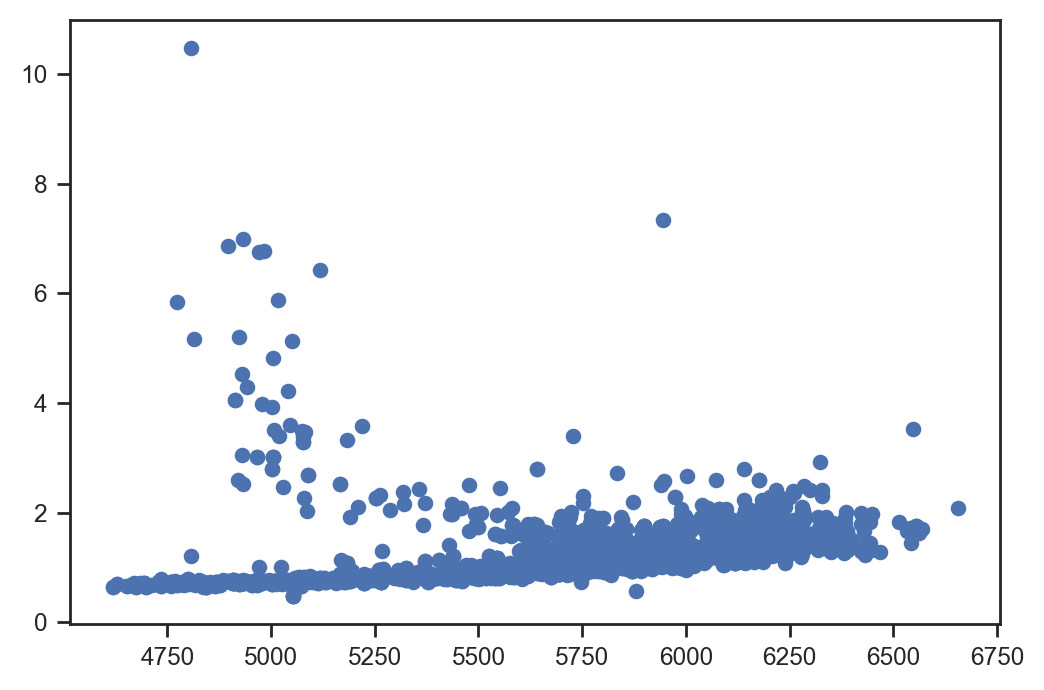

In [122]:
from scipy import interpolate 

#Non-rotating solar metallicity MIST isochrones
mist  = np.genfromtxt(data_dir+'mist/MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.iso', skip_header=10, names=True)
#Non-rotating Fe/H = -0.25 MIST isochrones
mistm = np.genfromtxt(data_dir+'mist/MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_m0.25_afe_p0.0_vvcrit0.0_basic.iso', skip_header=10, names=True)
#Non-rotating Fe/H = +0.25 MIST isochrones
mistp = np.genfromtxt(data_dir+'mist/MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.25_afe_p0.0_vvcrit0.0_basic.iso', skip_header=10, names=True)
#Rotating (v/vcrit=0.4) solar metallicity MIST isochrones
mistr = np.genfromtxt(data_dir+'mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso', skip_header=10, names=True)

# Improved MS cut
def maxage_teff(rstar):
    arg = (mistp['log10_isochrone_age_yr']==10.25)&(mistp['EEP']<500)
    f = interpolate.interp1d(10.**mistp['log_R'][arg], 
                             10.**mistp['log_Teff'][arg], 
                             kind='cubic', fill_value='extrapolate')
    return f(rstar)


_teff = np.linspace(4500,7000,10)

#We wish to remove stars that obviously fall below the main sequence as these may have unreliable stellar parameters
m_onms = cks['f18_R'] > 10.**((cks['f18_Teff']-5500)/7000 - 0.15)
#Our study will focus stars which have not evolved far off the main sequence
m_unevolved = cks['f18_R'] < 10.**((cks['f18_Teff']-5500)/4500 + 0.25)
#Some cool stars appear to be elevated from the main-sequence, corresponding to ages older than the universe
#even if they are metal-rich.
m_unelevated = cks['f18_Teff'] > maxage_teff(cks['f18_R'])

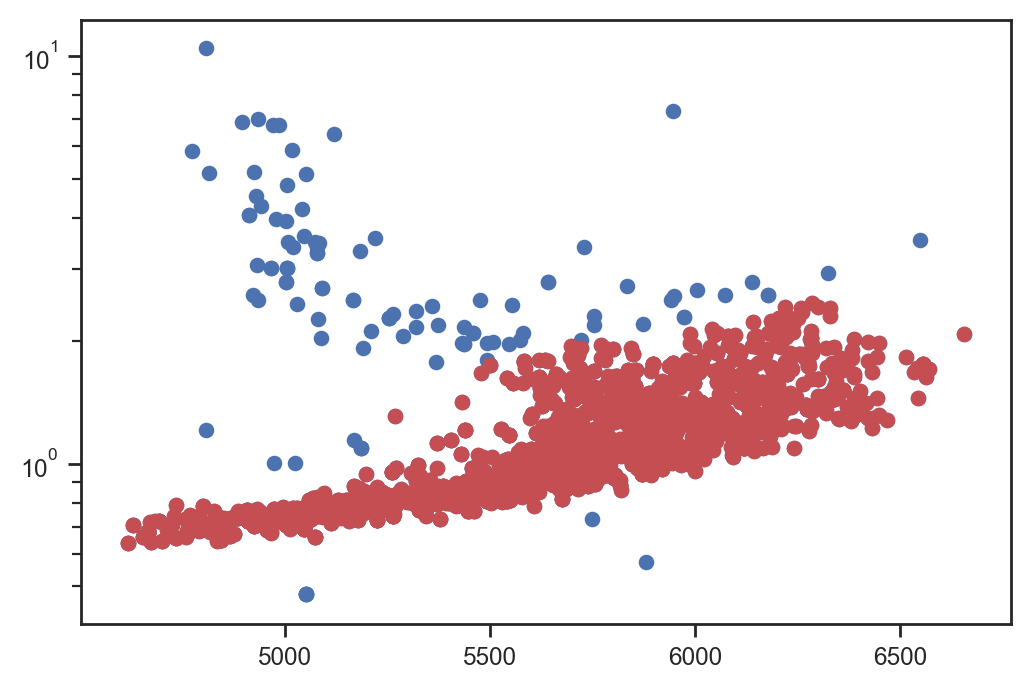

In [131]:
m_ms = m_onms & m_unevolved & m_unelevated

plt.scatter(cks['f18_Teff'], cks['f18_R'])
plt.scatter(cks['f18_Teff'][m_ms], cks['f18_R'][m_ms], color='r')
plt.semilogy()
plt.show()

### Masks

In [462]:
mstar_min, mstar_max = 0.75, 1.25
period_max = 100.
r8_max = 1.1
rcf_max = 1.05
abs_feh_max = 0.15
ruwe_max = 1.4

ag_max = 2
gkp_max = 1.0
snr_min = 0.5
dlogage_max = 1.0

print(len(cks), 'planets')

# Remove False Positives
m_fp = cks['p17_Disp'] != 'FP'
print(len(cks[~m_fp]), 'planets with FP disposition')

# Remove stars with flux contamination determined from Gaia
m_r8 = cks['f18_r8'] < r8_max
print(len(cks[~m_r8]), 'planets fail r8 cut')

# Exclude stars with flux contamination from follow-up high-res imaging
m_RCF = np.invert(cks['f18_RCF'] >= rcf_max)
print(len(cks[~m_RCF]), 'planets fail RCF cut')

# Exclude any subgiants or giants
m_Rstar = cks['f18_R'] < cks['Rcut']
print(len(cks[~m_Rstar]), 'planets fail stellar radius cut')

# Exclude long period planets
m_P = cks['f18_P'] < period_max
print(len(cks[~m_P]), 'planets fail period cut')

# Limit the stellar masses
m_stellarMass = (mstar_min<=cks['f18_Miso']) & (cks['f18_Miso']<=mstar_max)
print(len(cks[~m_stellarMass]), 'planets fail stellar mass cut')

# Limit the metallicity
m_FeH = abs(cks['f18_[Fe/H]'])<abs_feh_max
print(len(cks[~m_FeH]), 'planets fail stellar metallicity cut')

# No transit depth disagreement between FP2018 and DR25
m_transistdepth = abs(cks['f18_depth_ppm'] - cks['dr25_koi_depth'])<10000
print(len(cks[~m_transistdepth]), 'planets fail transit depth agreement cut')

# Signal-to-noise cut
m_snr = cks['single_transit_snr'] > snr_min
print(len(cks[~m_snr]), 'planets fail SNR cut')

m_snr25 = cks['single_transit_snr'] > 0.25
print(len(cks[~m_snr25]), 'planets fail SNR cut')

# Age disagreement between FP18 and B20
m_disagreementage = abs(cks['f18_logAiso'] - cks['b20_log10_iso_age'])< dlogage_max
print(len(cks[~m_disagreementage]), 'planets fail age agreement test')

# Well-determined planet radii
m_radiusprec = np.all(np.array([cks['f18_e_Rp']/cks['f18_Rp'], cks['f18_E_Rp']/cks['f18_Rp']])<0.10, axis=0)
print(len(cks[~m_radiusprec]), 'planets fail radius precision cut')

# Small planets
m_Rpmin = cks['f18_Rp']<10.0
print(len(cks[~m_Rpmin]), 'planets fail radius cut')

# RUWE cut // binary
m_ruwe = cks['d20_ruwe']<ruwe_max
print(len(cks[~m_ruwe]), 'planets fail RUWE cut')

# Stars with discrepant Kp and Gaia mags
m_magdisagree = abs(cks['gaia_phot_g_mean_mag']-cks['dr25_koi_kepmag'])<gkp_max
print(len(cks[~m_magdisagree]), 'planets fail Gaia-Kepler brightness agreement test')

# Stars with low Gaia reddening
m_red = cks['gaia_a_g_val']<ag_max
print(len(cks[~m_red]), 'planets fail Gaia reddening cut')

# Stars with discrepant Gaia and isochrone parallaxes
m_parallaxagree = abs(cks['f18_plx']-cks['f18_plxspec'])/np.min(np.array([cks['f18_e_plxspec'],cks['f18_E_plxspec']]), axis=0) < 4
print(len(cks[~m_parallaxagree]), 'planets fail parallax agreement test')

# Planets with grazing transits
m_grazing = cks['p20_Rtau'] >= 0.6
print(len(cks[~m_grazing]), 'planets with grazing transits')

m_multi = cks['nplanets']>1

print(len(cks[~m_multi]), 'planets in single system')

m_logaisonan = ~cks['f18_e_logAiso'].isna()

print(len(cks[~m_logaisonan]), 'planets have undefined error logAiso')

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 

#m1&m2&m3&m4&m5&m9&m11&m12&m17



# m = ful_planet['nplanets'] > 1  x
# #print(len(ful_planet[m]))
# m &= ful_planet['P'] < 100         x
# print(len(ful_planet[m]))
# m &= ful_planet['snr_min'] > 0.5   x    
# print(len(ful_planet[m]))
# m &= ful_planet['R'] < 1.5        x lsightly diff
# print(len(ful_planet[m]))
# m &= ful_planet['r8'] < 1.1          x 
# print(len(ful_planet[m]))
# m &= np.invert(ful_planet['RCF'] > 1.05)     x
# print(len(ful_planet[m]))
# m &= ful_planet['E_Rp']/ful_planet['Rp'] < 0.5   x
# print(len(ful_planet[m]))


print(len(cks[m]), 'planets remaining after cuts')
#print(len(cks[m_nplanets]), 'planets remaining after cuts and nplanets')
#not applying reddening cut
#not applying age agreement


m_noFeh = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_fp 

print(len(cks[m_noFeh]), 'planets remaining after cuts')

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_fp & m_FeH

print(len(cks[m]), 'planets remaining after cuts')


#m_transistdepth, m_disagreementage, m_Rpmin,m_magdisagree, m_red, m_parallaxagree, m_grazing, m_ruwe

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_fp & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe 

print(len(cks[m]), 'planets remaining after cuts')

1913 planets
149 planets with FP disposition
137 planets fail r8 cut
78 planets fail RCF cut
92 planets fail stellar radius cut
223 planets fail period cut
253 planets fail stellar mass cut
752 planets fail stellar metallicity cut
179 planets fail transit depth agreement cut
646 planets fail SNR cut
233 planets fail SNR cut
184 planets fail age agreement test
315 planets fail radius precision cut
153 planets fail radius cut
234 planets fail RUWE cut
140 planets fail Gaia-Kepler brightness agreement test
479 planets fail Gaia reddening cut
99 planets fail parallax agreement test
601 planets with grazing transits
736 planets in single system
9 planets have undefined error logAiso
603 planets remaining after cuts
595 planets remaining after cuts
357 planets remaining after cuts
244 planets remaining after cuts


/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less


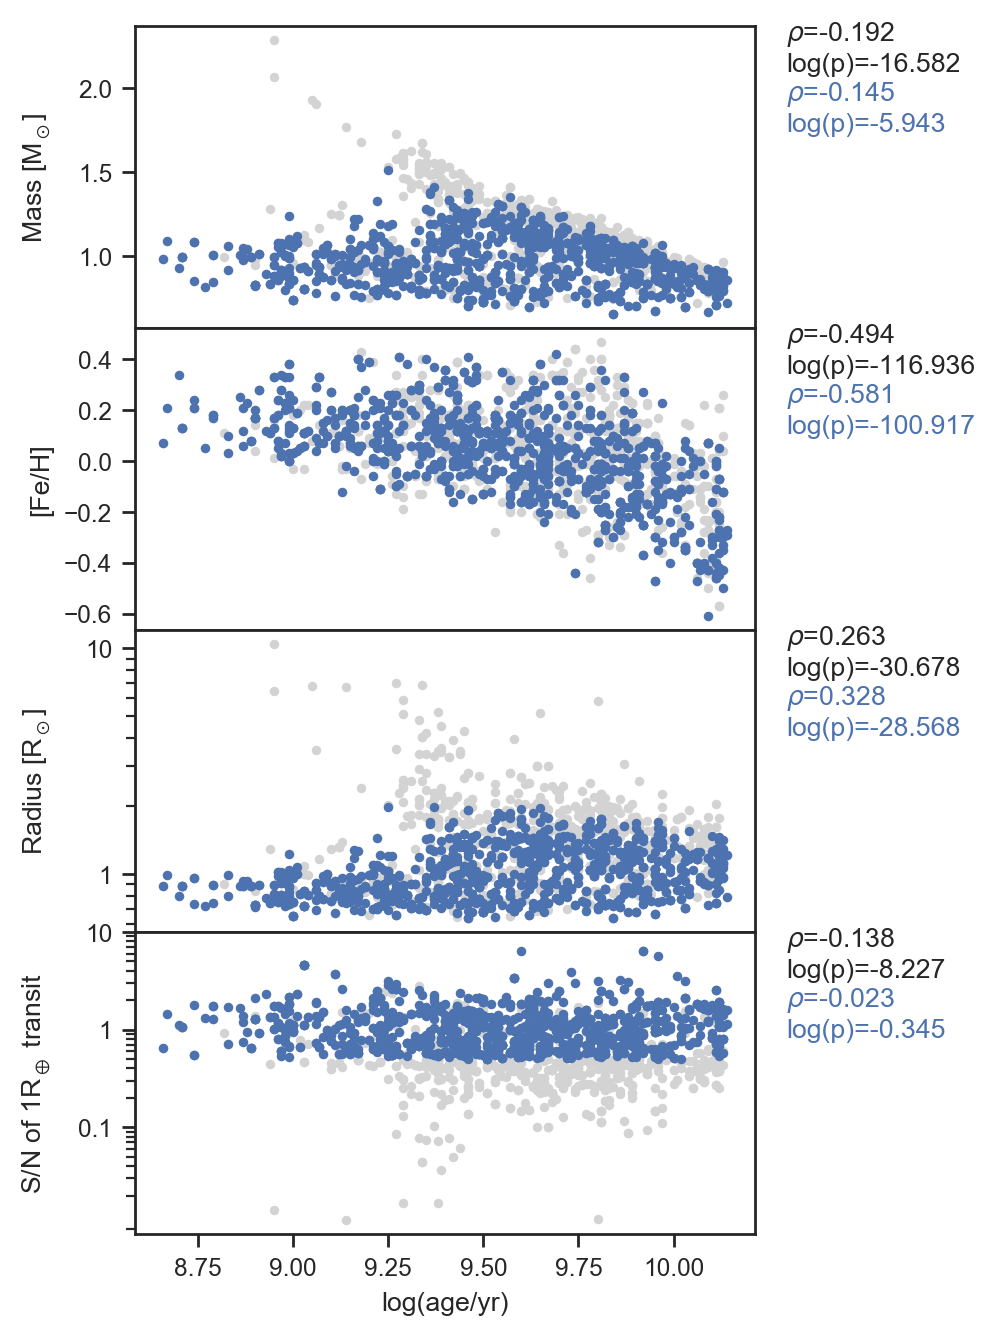

1913
1115


In [467]:
from scipy import stats


fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(4,8), sharex=True)

mask = m_fp & m_ms & m_P & m_snr

#m_r8 & m_RCF & m_ruwe 

age = cks['f18_logAiso']

variables = [cks['f18_Miso'], 
             cks['f18_[Fe/H]'],
             cks['f18_R'],
             cks['single_transit_snr']]


def f2str(n):
    return "{:.3f}".format(n)


for i,var in enumerate(variables):
    
    base = (np.isfinite(age)) & (np.isfinite(var))
    newm = mask&base
    
    
    rho1, pval1 = stats.spearmanr(age[base], var[base])
    rho2, pval2 = stats.spearmanr(age[newm], var[newm])
    
    
    ax[i].plot(age, var, '.', color='lightgrey')    
    ax[i].plot(age[newm], var[newm], '.', color='b')
    ax[i].text(1.05,0.85,r'$\rho$='+f2str(rho1)+'\nlog(p)='+f2str(np.log10(pval1)), transform=ax[i].transAxes)    
    ax[i].text(1.05,0.65,r'$\rho$='+f2str(rho2)+'\nlog(p)='+f2str(np.log10(pval2)), transform=ax[i].transAxes, color='b')
    
    if i>=2:
        ax[i].semilogy()
        

ax[2].set_yticks([1,10])        
ax[2].set_yticklabels(['1','10'])        

ax[3].set_xlabel('log(age/yr)')        
ax[3].set_yticks([0.1,1,10])
ax[3].set_yticklabels(['0.1','1','10'])
#ax[3].axhline(snr_min, **line_kwargs)

ax[0].set_ylabel(r'Mass [$\mathregular{M_\odot}$]')
ax[1].set_ylabel('[Fe/H]')
ax[2].set_ylabel(r'Radius [$\mathregular{R_\odot}$]')
ax[3].set_ylabel(r'S/N of 1$\mathregular{R_\oplus}$ transit')        

plt.subplots_adjust(hspace=0)
#plt.tight_layout()
fig.align_ylabels(ax)
plt.show()

print(len(age))
print(len(age[mask]))

8.5
9.0
9.5
10.0


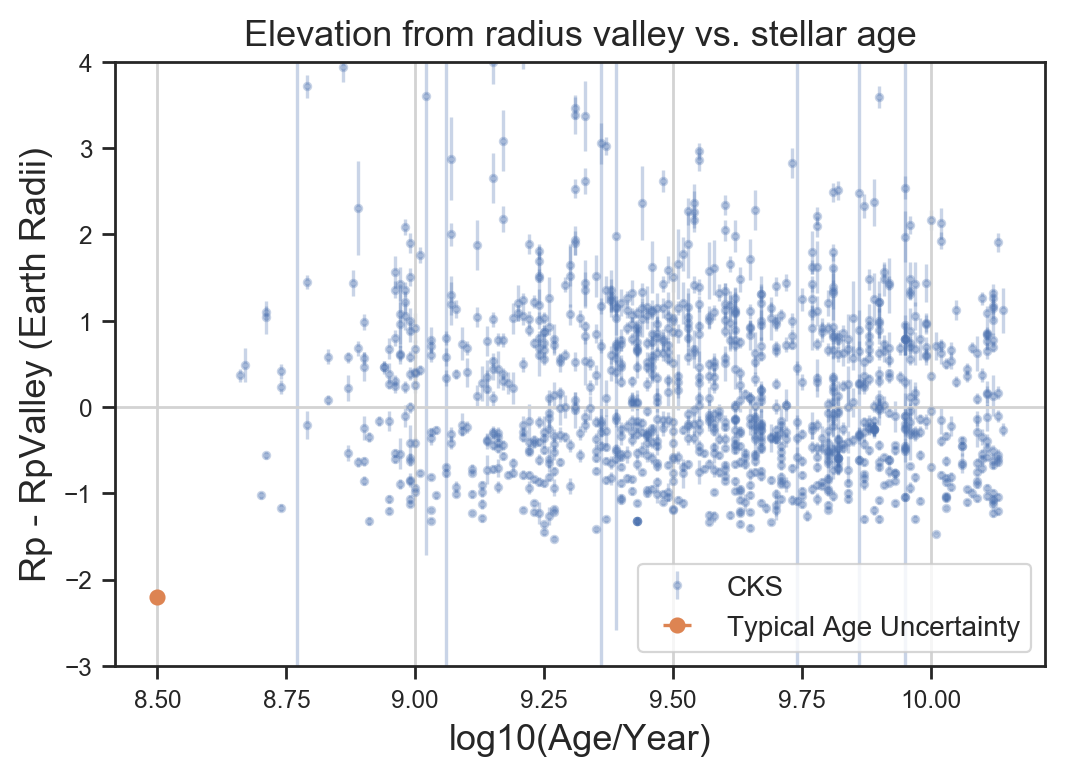

In [468]:
def Rp_valley(P, ref='D20'):
    if ref=='V18':
        a, b = -0.09, 0.37
    elif ref=='D20':
        a, b = -0.08, 0.31
    elif ref=='RO20':
        a, b = 0.0, np.log10(1.8)
    return 10**(a*np.log10(P) + b)

# To factor in uncertainties
# def Rp_valley(P, ref='D20'):
#     if ref=='V18':
#         a, b = np.random.normal(-0.09, 0.03), np.random.normal(0.37, 0.03)
#     elif ref=='D20':
#         a, b = np.random.normal(-0.08, 0.05), np.random.normal(0.31, 0.05)
#     elif ref=='RO20':
#         a, b = 0.0, np.log10(np.random.uniform(1.56,1.87))
#     return 10**(a*np.log10(P) + b)

    
cks["Rp_valley"] = Rp_valley(cks['f18_P'])
cks['R_diff'] = cks["f18_Rp"] - cks["Rp_valley"]

#short_period = ful_planet["P"] < 30
#long_period = ful_planet["P"] > 30
#plt.scatter(ful_planet["logAiso"][short_period],ful_planet["R_diff"][short_period],s = 8,alpha = 0.3, label = "Short Period")
plt.errorbar(cks["f18_logAiso"][m],cks["R_diff"][m], yerr = [cks['f18_e_Rp'][m], cks['f18_E_Rp'][m]], fmt = '.',alpha = 0.3, label = 'CKS')
plt.errorbar(8.5, -2.2, xerr=np.median(cks['f18_E_logAiso'][m]), fmt='o', label = 'Typical Age Uncertainty') #typical uncertainty in stellar age
plt.legend(prop = {'size': 10}, loc = 'lower right')
plt.xlabel("log10(Age/Year)",size = 13)
plt.ylabel("Rp - RpValley (Earth Radii)",size = 13)
plt.title('Elevation from radius valley vs. stellar age',size = 13)
plt.ylim(-3,4)
plt.axhline(0, color = 'lightgrey', lw = 1)

_bins = np.arange(8.5,10.5,0.5)
for b in _bins:
    plt.axvline(b, color = 'lightgrey', lw = 1)
    print(b)
#plt.savefig("rp-rpvalley.jpg",bbox_inches='tight',dpi = 300)

In [80]:
def uniform_sampling(cks, m, _binwidth=0.5, nsamples = 1000):
    

    _rvalley = cks['Rp_valley'][m]

    _minage = 8
    _maxage = 12
    _bins = np.arange(_minage,_maxage,_binwidth)

    _ratio = []

    for i in range(nsamples):

        # In this step we simulate a data set with similar properties to the true data set.
        # We model both planet radius and age as Gaussian distributions centered on the measured values (rp and age)
        # and standard deviations equal to the previously assigned errors (_e)

        # Implicit in this step is that the stellar age and planet radius measurements/uncertainties are independent.
        # It is probably not true that age and radius uncertainties are independent, but we can assess the degree to
        # which that impacts our results later on.

        # In reality, we have asymmetric error bars on rp and age. We have to make a decision on how to deal with this.
        # If a given planet has a radius of 1.0(+0.3, -0.1) and age of 9.5(+0.5,-0.25) we could just take the maximum error
        # in both radius and age and continue to model as Gaussians, e.g. radius is 1.0 +/- 0.3, and age is 9.5 +/- 0.5
        # in the example above.

        _rp = np.random.normal(cks['f18_Rp'][m], np.max([cks['f18_e_Rp'][m],cks['f18_E_Rp'][m]], axis=0))
        _age = np.random.uniform(cks['f18_logAiso'][m]-cks['f18_e_logAiso'][m],cks['f18_logAiso'][m]+cks['f18_E_logAiso'][m])
        _above = _rp >= _rvalley
        _below = _rp < _rvalley

        _hist1, _bin_edges = np.histogram(_age[_above], bins=_bins)
        _hist2, _bin_edges = np.histogram(_age[_below], bins=_bins)


        _ratio.append(_hist2/_hist1)
    
    bin_centers = 0.5*(_bin_edges[1:]+_bin_edges[:-1])    
    return _ratio, bin_centers, _bin_edges

In [81]:
# _age = np.random.normal(cks['f18_logAiso'][m], np.max([cks['f18_e_logAiso'][m],cks['f18_E_logAiso'][m]], axis=0))
def normal_sampling(cks, m, _binwidth=0.5, nsamples = 1000):
    
    _rvalley = cks['Rp_valley'][m]

    _minage = 8
    _maxage = 12
    _bins = np.arange(_minage,_maxage,_binwidth)

    _ratio = []

    for i in range(nsamples):

        # In this step we simulate a data set with similar properties to the true data set.
        # We model both planet radius and age as Gaussian distributions centered on the measured values (rp and age)
        # and standard deviations equal to the previously assigned errors (_e)

        # Implicit in this step is that the stellar age and planet radius measurements/uncertainties are independent.
        # It is probably not true that age and radius uncertainties are independent, but we can assess the degree to
        # which that impacts our results later on.

        # In reality, we have asymmetric error bars on rp and age. We have to make a decision on how to deal with this.
        # If a given planet has a radius of 1.0(+0.3, -0.1) and age of 9.5(+0.5,-0.25) we could just take the maximum error
        # in both radius and age and continue to model as Gaussians, e.g. radius is 1.0 +/- 0.3, and age is 9.5 +/- 0.5
        # in the example above.

        _rp = np.random.normal(cks['f18_Rp'][m], np.max([cks['f18_e_Rp'][m],cks['f18_E_Rp'][m]], axis=0))
        #_age = np.random.uniform(cks['f18_logAiso'][m]-cks['f18_e_logAiso'][m],cks['f18_logAiso'][m]+cks['f18_E_logAiso'][m])
        _age = np.random.normal(cks['f18_logAiso'][m], np.max([cks['f18_e_logAiso'][m],cks['f18_E_logAiso'][m]], axis=0))

        _above = _rp >= _rvalley
        _below = _rp < _rvalley

        _hist1, _bin_edges = np.histogram(_age[_above], bins=_bins)
        _hist2, _bin_edges = np.histogram(_age[_below], bins=_bins)


        _ratio.append(_hist2/_hist1)
    
    bin_centers = 0.5*(_bin_edges[1:]+_bin_edges[:-1])    
    return _ratio, bin_centers, _bin_edges

In [218]:
# np.random.seed(123)
# x  = [3.0, 4.0, 5.0, 6.0]
# xerr = [0.1, 0.3, 0.1, 0.05]
# xsim = np.array([np.random.normal(x, xerr) for n in range(3)])

# print(np.shape(xsim))
# #print(xsim[xsim<3.])

In [217]:
# age_med = 9.3
# age_err = np.array([0.1, 0.3]) #(9.2-9.6)

# #print(np.max(age_err, axis=0))

# agemodel = np.random.normal(age_med, np.max(age_err, axis=0), int(1e5))
# agemodel_uni = np.random.uniform(age_med - age_err[0], age_med + age_err[1], int(1e5))

# plt.hist(agemodel, bins=100, histtype='step', color='k')
# plt.hist(agemodel_uni, bins=100, histtype='step', color='grey')
# plt.axvline(np.median(agemodel), color='b')
# plt.axvspan(np.percentile(agemodel, 16), np.percentile(agemodel, 84), color='b', alpha=0.3)

# plt.axvline(9.3, color='r')
# plt.axvspan(9.3-0.1, 9.3+0.3, alpha=0.3, color='r')
# plt.show()

# #CDF
# age_med = 9.3
# age_err = np.array([0.1, 0.3]) #(9.2-9.6)

# cdfx = [0., 16., 50., 84., 100.]
# cdfy = [8.0, age_med-age_err[0], age_med, age_med + age_err[1], 10.2]

# plt.scatter(cdfy, cdfx)
# plt.show()

In [82]:
from tqdm import tqdm 

def new_fn(cks, m, _binwidth=0.125, nsamples=1000, age_ref='cks'):
    
    bin_centers = np.linspace(8.25,10.25,50)
    ratio = np.zeros([len(bin_centers), nsamples])
    
    if age_ref == 'cks':
        age_med, age_err_lo, age_err_hi = cks['f18_logAiso'], cks['f18_e_logAiso'], cks['f18_E_logAiso']

    elif age_ref == 'berger':
        age_med, age_err_lo, age_err_hi = cks['b20_log10_iso_age'], cks['b20_e_log10_iso_age'], cks['b20_E_log10_iso_age']     
            
    #mc_age = [np.random.normal(age_med, np.max([age_err_lo, age_err_hi], axis=0)) for n in range(nsamples)]
    #mc_p = [np.random.normal(age_med, np.max([age_err_lo, age_err_hi], axis=0)) for n in range(nsamples)]
    
    for i in tqdm(range(len(bin_centers))):
        for j in range(nsamples):
                                   
            mc_age = np.random.normal(age_med, np.max([age_err_lo, age_err_hi], axis=0))            
            
            mask = m & (mc_age>=bin_centers[i]-_binwidth) & (mc_age<bin_centers[i]+_binwidth)
            
            mc_p  = cks['f18_P'][mask]
            
            
            #mc_slope = np.random.normal()
            #mc_intercept = np.random.normal()
            
            mc_rp = np.random.normal(cks['f18_Rp'][mask], 
                                     np.max([cks['f18_e_Rp'][mask], cks['f18_E_Rp'][mask]], axis=0)) - Rp_valley(mc_p)
            
            
            
            try:
                ratio[i,j] = len(mc_rp[mc_rp<0])/len(mc_rp[mc_rp>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    
    return bin_centers, ratio

# bin_centers, _ratio = new_fn(cks, m=m_FP&m_P&m_Rpmin&m_Rstar&m_snr&(cks['f18_Teff']>5500), 
#                              _binwidth=0.25, age_ref='berger', nsamples=100)


m = m_FP&m_Rpmin&m_Rstar&m_snr&(cks['f18_P']<60.) & (abs(cks['f18_Miso']-1.0)<0.1)

#m = m_FP&m_P&m_Rpmin&m_Rstar&m_snr&m_grazing
m_all = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe 

bin_centers, _ratio = new_fn(cks, m=m, 
                              _binwidth=0.25, age_ref='cks', nsamples=100)


  0%|          | 0/50 [00:00<?, ?it/s]/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


In [469]:
def new_fn_speed(cks, m, _binwidth=0.125, nsamples=1000, age_ref='cks', rv_ref='D20'):
    
    #bin_centers = np.linspace(8.25,10.25,50)
    bin_centers = np.linspace(8.25,10,50)
    ratio = np.zeros([len(bin_centers), nsamples])
    
    if age_ref == 'cks':
        age_med, age_err_lo, age_err_hi = cks['f18_logAiso'], cks['f18_e_logAiso'], cks['f18_E_logAiso']
    elif age_ref == 'berger':
        age_med, age_err_lo, age_err_hi = cks['b20_log10_iso_age'], cks['b20_e_log10_iso_age'], cks['b20_E_log10_iso_age']     
            
    mc_age = np.array([np.random.normal(age_med, np.max([age_err_lo, age_err_hi], 
                                                        axis=0)) for n in range(nsamples)])
    m_duplic = np.repeat([m], nsamples, axis=0)
    
    p_duplic = np.repeat([cks['f18_P']], nsamples, axis=0)
    
    Rp_duplic = np.repeat([cks['f18_Rp']], nsamples, axis=0)
    ERp_dupl =  np.repeat([cks['f18_E_Rp']], nsamples, axis=0)
    eRp_dupl =  np.repeat([cks['f18_e_Rp']], nsamples, axis=0)
    
    mc_rp = np.random.normal(Rp_duplic, 
                                 np.max([ERp_dupl,eRp_dupl], axis=0)) - Rp_valley(p_duplic, ref=rv_ref)
    
    #for i in tqdm(range(len(bin_centers))):
    for i in range(len(bin_centers)):          
        mask = m_duplic & (mc_age>=bin_centers[i]-_binwidth) & (mc_age<bin_centers[i]+_binwidth)
   
        for j in range(nsamples):
            mc_rp_ = mc_rp[j][mask[j]]
            
            try:
                ratio[i,j] = len(mc_rp_[mc_rp_<0])/len(mc_rp_[mc_rp_>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    
    return bin_centers, ratio


### Action items
1. Include radius valley uncertainties
2. Completeness - make maps for stars in finer age bins, take dr25_kepid, f18_Miso, f18_R, f18_logAiso
-Send Angeli email on this
3. What is the best way to present sensitivity to masks? TD consider what masks are needed what are not
4. (Mass-dependence to radius valley (TD to consider how to handle this - maybe just restrict range of masses))
5. Keep Google notes up to date (what each mask is important for)
6. (CDF age analysis (think about how to do this))
7. (Occurrence rate (TD try first attempt w/ Berger))

In [470]:
#v18, d20, flat line (rogers & owen)
#3sigma above/below

m = m_FP & m_ms & m_P & m_snr 
    #(abs(cks['f18_[Fe/H]'])<0.2)# &\
    #(cks['f18_R']<1.1)

bin_centers, _ratio = new_fn_speed(cks, m=mask, 
                              _binwidth=0.5, age_ref='cks', rv_ref='D20', nsamples=1000)

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater_equal
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


0.8003235541722254 0.10597897871620743
0.9903259597816215 0.0743238215393237
0.8241547143492195 0.10535016306061307
1.0207503975974759 0.05066872097167633


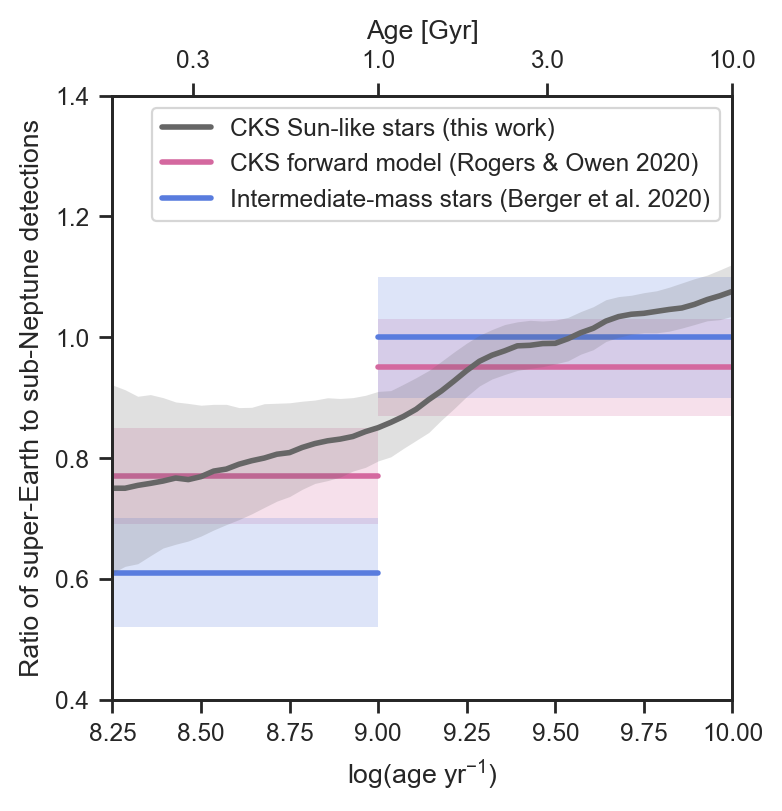

In [471]:
#Google "hex color picker" and pick your preferred color
#clr = '#d4689f'
clr = '#666666'

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twiny()


ax.plot(bin_centers, np.nanmedian(_ratio, axis=1), color=clr, label='CKS Sun-like stars (this work)', lw=2, zorder=999)

#for ci in [68.3,95.4,99.7]:
for ci in [68.3]:
    ax.fill_between(bin_centers, 
                 np.nanpercentile(_ratio, 50.-0.5*ci, axis=1), 
                 np.nanpercentile(_ratio, 50.+0.5*ci, axis=1), 
                 alpha=0.2, color=clr, lw=0, zorder=999)


#plt.xlabel(r'CKS log$_\mathregular{10}$(age yr$^\mathregular{-1}$)')
ax.set_xlabel(r'log(age yr$^\mathregular{-1}$)')
ax.set_ylabel('Ratio of super-Earth to sub-Neptune detections')


#Rogers & Owen 2020
#ro_color = '#597cde'
ro_color = '#d4689f'

ax.plot([8.25,9],[0.77,0.77], ro_color, label='CKS forward model (Rogers & Owen 2020)', lw=2)
ax.fill_between([8.25,9],0.77-0.08,0.77+0.08, alpha=0.2, color=ro_color, lw=0)
ax.plot([9,10.25],[0.95,0.95], ro_color, lw=2)
ax.fill_between([9,10.25],0.95-0.08,0.95+0.08, alpha=0.2, color=ro_color, lw=0)


#Berger et al. 2020
#be_color = '#666666'
#be_color = '#e3933d'
#be_color='#d4689f'
be_color = '#597cde'

ax.plot([8.25,9],[0.61,0.61], color=be_color, label='Intermediate-mass stars (Berger et al. 2020)', lw=2)
ax.fill_between([8.25,9],0.61-0.09,0.61+0.09, alpha=0.2, color=be_color, lw=0)
ax.plot([9,10.25],[1,1], color=be_color, lw=2)
ax.fill_between([9,10.25],1-0.1,1+0.1, alpha=0.2, color=be_color, lw=0)

#Fulton et al. 2017 Occurrence ratio
#plt.fill_between([8.25,10.25],0.8-0.2,0.8+0.2, alpha=0.2, color='g', lw=0)

ax.set_xlim(bin_centers.min(), bin_centers.max())
ax.set_ylim(0.4,1.4)
#plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', frameon=False)
ax.legend()


new_tick_locations = np.log10([3e8,1e9,3e9,1e10])

def tick_function(X):
    V = 10.**X/(1.0e9)
    return ["%.1f" % z for z in V]

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Age [Gyr]")

plt.gcf().set_size_inches(4,4)
#plt.savefig('./figures/ratio.pdf')


print(np.mean(_ratio[bin_centers<=9]), np.std(_ratio[bin_centers<=9]))
print(np.mean(_ratio[bin_centers>9]), np.std(_ratio[bin_centers>9]))

print(np.mean(_ratio[bin_centers<=9.25]), np.std(_ratio[bin_centers<=9.25]))
print(np.mean(_ratio[bin_centers>9.25]), np.std(_ratio[bin_centers>9.25]))

### What about the effects of mass and metallicity?

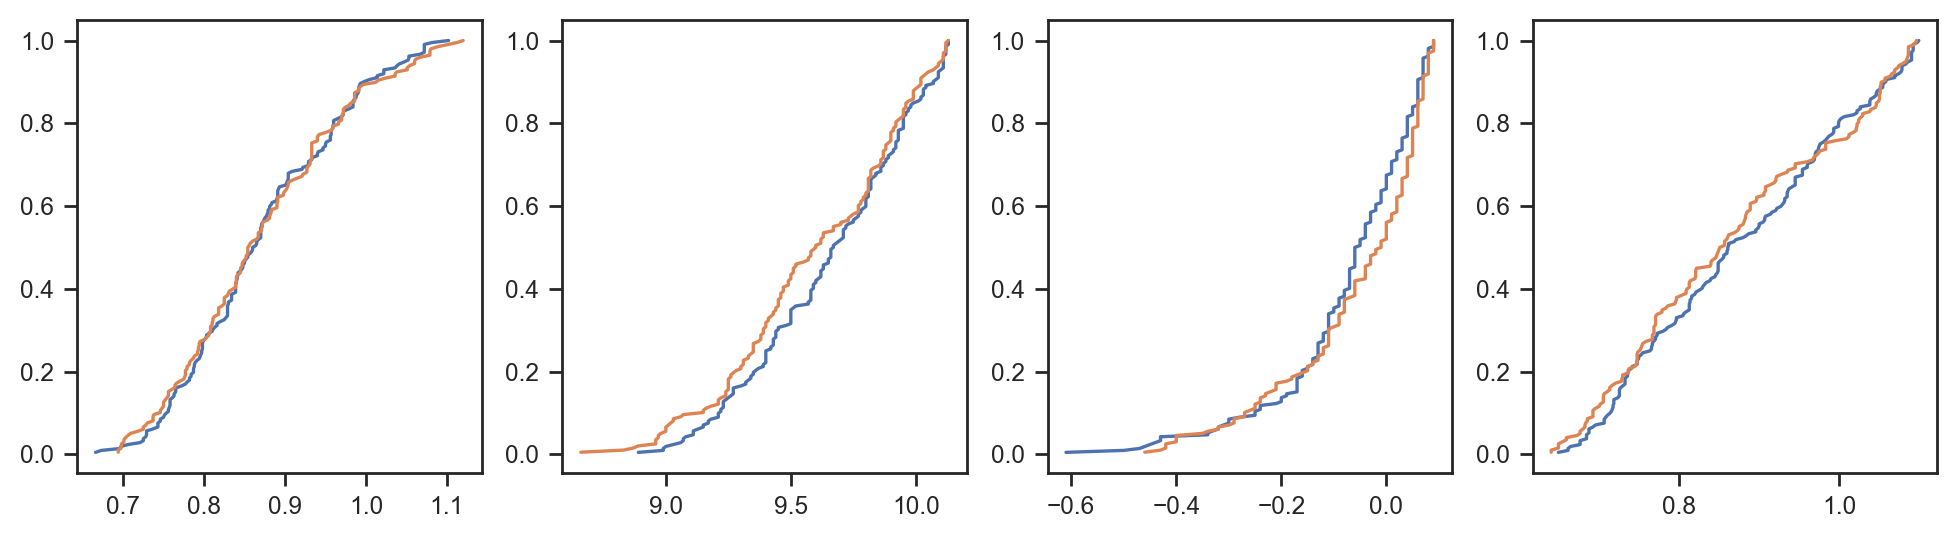

In [387]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)



se = m_FP & m_ms & m_radiusprec &\
    (cks['f18_Miso']>0) &\
    (cks['f18_P']<100) &\
    (cks['single_transit_snr']>0.4) &\
    (abs(cks['f18_[Fe/H]']<0.1)) &\
    (cks['f18_R']<1.1) &\
    (cks['f18_Rp']<1.8) 

sn = m_FP & m_ms & m_radiusprec &\
    (cks['f18_Miso']>0) &\
    (cks['f18_P']<100) &\
    (cks['single_transit_snr']>0.4) &\
    (abs(cks['f18_[Fe/H]']<0.1)) &\
    (cks['f18_R']<1.1) &\
    (cks['f18_Rp']>1.8)


for i,var in enumerate(['f18_Miso','f18_logAiso','f18_[Fe/H]','f18_R']):
    _xse, _yse = ecdf(cks[var][se])
    _xsn, _ysn = ecdf(cks[var][sn])
    
    plt.subplot(1,4,i+1)
    plt.plot(_xse, _yse)
    plt.plot(_xsn, _ysn)
            
plt.gcf().set_size_inches(12,3)
plt.show()
        
# plt.plot(_x, _y)
# _x, _y = ecdf(cks['f18_Miso'][sn])

# plt.show()

# _x, _y = ecdf(cks['f18_logAiso'][se])
# plt.plot(_x, _y)
# _x, _y = ecdf(cks['f18_logAiso'][sn])
# plt.plot(_x, _y)
# plt.show()


# _x, _y = ecdf(cks['f18_[Fe/H]'][se])
# plt.plot(_x, _y)
# _x, _y = ecdf(cks['f18_[Fe/H]'][sn])
# plt.plot(_x, _y)
# plt.show()

# _x, _y = ecdf(cks['f18_R'][se])
# plt.plot(_x, _y)
# _x, _y = ecdf(cks['f18_R'][sn])
# plt.plot(_x, _y)
# plt.show()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater_equal
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in less
/Users/tdavid/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/tdavid/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


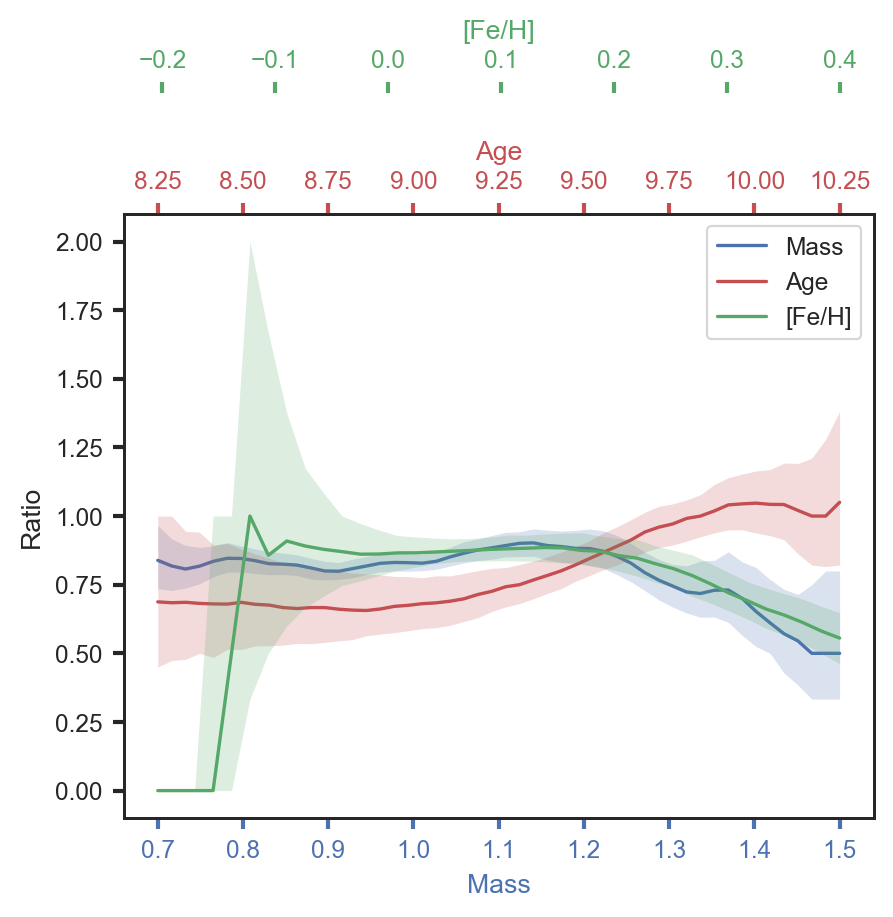

In [388]:
from scipy import stats
#stats.percentileofscore(cks['f18_Miso'], 0.69)


def feh_sim(cks, m, _binwidth=0.1, nsamples=1000, feh_ref='cks'):
    
    bin_centers = np.linspace(-0.4,0.4,50)
    ratio = np.zeros([len(bin_centers), nsamples])
    
    if feh_ref == 'cks':
        feh_med, feh_err_lo, feh_err_hi = cks['f18_[Fe/H]'], cks['f18_e_[Fe/H]'], cks['f18_E_[Fe/H]']
            
    mc_feh = np.array([np.random.normal(feh_med, np.max([feh_err_lo, feh_err_hi], 
                                                        axis=0)) for n in range(nsamples)])
    m_duplic = np.repeat([m], nsamples, axis=0)
    
    p_duplic = np.repeat([cks['f18_P']], nsamples, axis=0)
    
    Rp_duplic = np.repeat([cks['f18_Rp']], nsamples, axis=0)
    ERp_dupl =  np.repeat([cks['f18_E_Rp']], nsamples, axis=0)
    eRp_dupl =  np.repeat([cks['f18_e_Rp']], nsamples, axis=0)
    
    mc_rp = np.random.normal(Rp_duplic, 
                                 np.max([ERp_dupl,eRp_dupl], axis=0)) - Rp_valley(p_duplic)
    
    #for i in tqdm(range(len(bin_centers))):
    for i in range(len(bin_centers)):          
        mask = m_duplic & (mc_feh>=bin_centers[i]-_binwidth) & (mc_feh<bin_centers[i]+_binwidth)
   
        for j in range(nsamples):
            mc_rp_ = mc_rp[j][mask[j]]
            
            try:
                ratio[i,j] = len(mc_rp_[mc_rp_<0])/len(mc_rp_[mc_rp_>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    
    return bin_centers, ratio


def mass_sim(cks, m, _binwidth=0.1, nsamples=1000, feh_ref='cks'):
    
    bin_centers = np.linspace(0.7,1.5,50)
    ratio = np.zeros([len(bin_centers), nsamples])
    
    if feh_ref == 'cks':
        mass_med, mass_err_lo, mass_err_hi = cks['f18_Miso'], cks['f18_e_Miso'], cks['f18_E_Miso']
            
    mc_mass = np.array([np.random.normal(mass_med, 
                                         np.max([mass_err_lo, mass_err_hi], axis=0)) for n in range(nsamples)])
    m_duplic = np.repeat([m], nsamples, axis=0)
    
    p_duplic = np.repeat([cks['f18_P']], nsamples, axis=0)
    
    Rp_duplic = np.repeat([cks['f18_Rp']], nsamples, axis=0)
    ERp_dupl =  np.repeat([cks['f18_E_Rp']], nsamples, axis=0)
    eRp_dupl =  np.repeat([cks['f18_e_Rp']], nsamples, axis=0)
    
    mc_rp = np.random.normal(Rp_duplic, 
                                 np.max([ERp_dupl,eRp_dupl], axis=0)) - Rp_valley(p_duplic)
    
    for i in range(len(bin_centers)):          
        mask = m_duplic & (mc_mass>=bin_centers[i]-_binwidth) & (mc_mass<bin_centers[i]+_binwidth)
   
        for j in range(nsamples):
            mc_rp_ = mc_rp[j][mask[j]]
            
            try:
                ratio[i,j] = len(mc_rp_[mc_rp_<0])/len(mc_rp_[mc_rp_>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    
    return bin_centers, ratio



def mc_sim(cks, m, var, nsamples=1000):
    
    if var=='mass':
        bin_centers = np.linspace(0.7,1.5,50)
        #_binwidth = 0.2
        _med, _err_lo, _err_hi = cks['f18_Miso'], cks['f18_e_Miso'], cks['f18_E_Miso']
    elif var=='feh':
        bin_centers = np.linspace(-0.4,0.4,50)
        #_binwidth = 0.3
        _med, _err_lo, _err_hi = cks['f18_[Fe/H]'], cks['f18_e_[Fe/H]'], cks['f18_E_[Fe/H]']
    elif var=='age': 
        bin_centers = np.linspace(8.25,10.25,50)
        #_binwidth = 0.5
        _med, _err_lo, _err_hi = cks['f18_logAiso'], cks['f18_e_logAiso'], cks['f18_E_logAiso']
    
    
    _binwidth = 2.*3.49*np.std(_med[m])/(len(_med[m])**(1./3.))
                            
    ratio = np.zeros([len(bin_centers), nsamples])

    mc_var = np.array([np.random.normal(_med, 
                                         np.max([_err_lo, _err_hi], axis=0)) for n in range(nsamples)])
    m_duplic = np.repeat([m], nsamples, axis=0)
    
    p_duplic = np.repeat([cks['f18_P']], nsamples, axis=0)
    
    Rp_duplic = np.repeat([cks['f18_Rp']], nsamples, axis=0)
    ERp_dupl =  np.repeat([cks['f18_E_Rp']], nsamples, axis=0)
    eRp_dupl =  np.repeat([cks['f18_e_Rp']], nsamples, axis=0)
    
    mc_rp = np.random.normal(Rp_duplic, 
                                 np.max([ERp_dupl,eRp_dupl], axis=0)) - Rp_valley(p_duplic)
    
    for i in range(len(bin_centers)):          
        mask = m_duplic & (mc_var>=bin_centers[i]-_binwidth) & (mc_var<bin_centers[i]+_binwidth)
   
        for j in range(nsamples):
            mc_rp_ = mc_rp[j][mask[j]]
            
            try:
                ratio[i,j] = len(mc_rp_[mc_rp_<0])/len(mc_rp_[mc_rp_>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    #stats.percentileofscore(_med[m], bin_centers), 
    return bin_centers, ratio 





def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)





_x = np.arange(50)

m = m_FP & m_ms &\
    (cks['f18_P']<100) &\
    (cks['single_transit_snr']>0.4)

m = m_FP & m_ms & m_radiusprec &\
    (cks['f18_P']<100) &\
    (cks['single_transit_snr']>0.4) &\
    (cks['f18_[Fe/H]']>0.0)
    #(cks['f18_R']<1.1)



colors = ['r','g','b']
variables = ['mass', 'age', 'feh']

#fig = plt.figure()
#ax = fig.add_subplot(111)

fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twiny()
par2 = host.twiny()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["top"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)




mass_bin_centers, mass_ratio = mc_sim(cks, m=m, var='mass')
feh_bin_centers, feh_ratio = mc_sim(cks, m=m, var='feh')
age_bin_centers, age_ratio = mc_sim(cks, m=m, var='age')


p1, = host.plot(mass_bin_centers, np.nanmedian(mass_ratio, axis=1), "b-", label="Mass")
p2, = par1.plot(age_bin_centers, np.nanmedian(age_ratio, axis=1), "r-", label="Age")
p3, = par2.plot(feh_bin_centers, np.nanmedian(feh_ratio, axis=1), "g-", label="[Fe/H]")

ci = 68.3

host.fill_between(mass_bin_centers, 
                        np.nanpercentile(mass_ratio, 50.-0.5*ci, axis=1), 
                        np.nanpercentile(mass_ratio, 50.+0.5*ci, axis=1), 
                        alpha=0.2, color='b', lw=0, zorder=999)

par1.fill_between(age_bin_centers, 
                        np.nanpercentile(age_ratio, 50.-0.5*ci, axis=1), 
                        np.nanpercentile(age_ratio, 50.+0.5*ci, axis=1), 
                        alpha=0.2, color='r', lw=0, zorder=999)

par2.fill_between(feh_bin_centers, 
                        np.nanpercentile(feh_ratio, 50.-0.5*ci, axis=1), 
                        np.nanpercentile(feh_ratio, 50.+0.5*ci, axis=1), 
                        alpha=0.2, color='g', lw=0, zorder=999)



# for i,var in enumerate(variables):
    
#     ax2 = ax.twiny()

    


#     ax2.plot(bin_centers, np.nanmedian(_ratio, axis=1), color=colors[i], lw=2, zorder=999)

#     for ci in [68.3]:
#         ax2.fill_between(bin_centers, 
#                         np.nanpercentile(_ratio, 50.-0.5*ci, axis=1), 
#                         np.nanpercentile(_ratio, 50.+0.5*ci, axis=1), 
#                         alpha=0.2, color=colors[i], lw=0, zorder=999)
    
    
    
    

host.set_ylabel("Ratio")
host.set_xlabel("Mass")
par1.set_xlabel("Age")
par2.set_xlabel("[Fe/H]")

host.xaxis.label.set_color(p1.get_color())
par1.xaxis.label.set_color(p2.get_color())
par2.xaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='x', colors=p1.get_color(), **tkw)
par1.tick_params(axis='x', colors=p2.get_color(), **tkw)
par2.tick_params(axis='x', colors=p3.get_color(), **tkw)
host.tick_params(axis='y', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines])

    
    
# bin_centers, _ratio = mc_sim(cks, m=m, var='feh')

# ax.plot(_x, np.nanmedian(_ratio, axis=1), color=clr, label='CKS Sun-like stars (this work)', lw=2, zorder=999)

# for ci in [68.3]:
#     ax.fill_between(_x, 
#                  np.nanpercentile(_ratio, 50.-0.5*ci, axis=1), 
#                  np.nanpercentile(_ratio, 50.+0.5*ci, axis=1), 
#                  alpha=0.2, color=clr, lw=0, zorder=999)

# #bin_centers, _ratio = new_fn_speed(cks, m=m, 
# #                              _binwidth=0.5, age_ref='cks', nsamples=1000)
# bin_centers, _ratio = mc_sim(cks, m=m, var='age')
    

# ax.plot(_x, np.nanmedian(_ratio, axis=1), color=clr, label='CKS Sun-like stars (this work)', lw=2, zorder=999)

# for ci in [68.3]:
#     ax.fill_between(np.arange(50), 
#                  np.nanpercentile(_ratio, 50.-0.5*ci, axis=1), 
#                  np.nanpercentile(_ratio, 50.+0.5*ci, axis=1), 
#                  alpha=0.2, color=clr, lw=0, zorder=999)
    

plt.show()

0
94
154
209
297
349
433
510
563
613


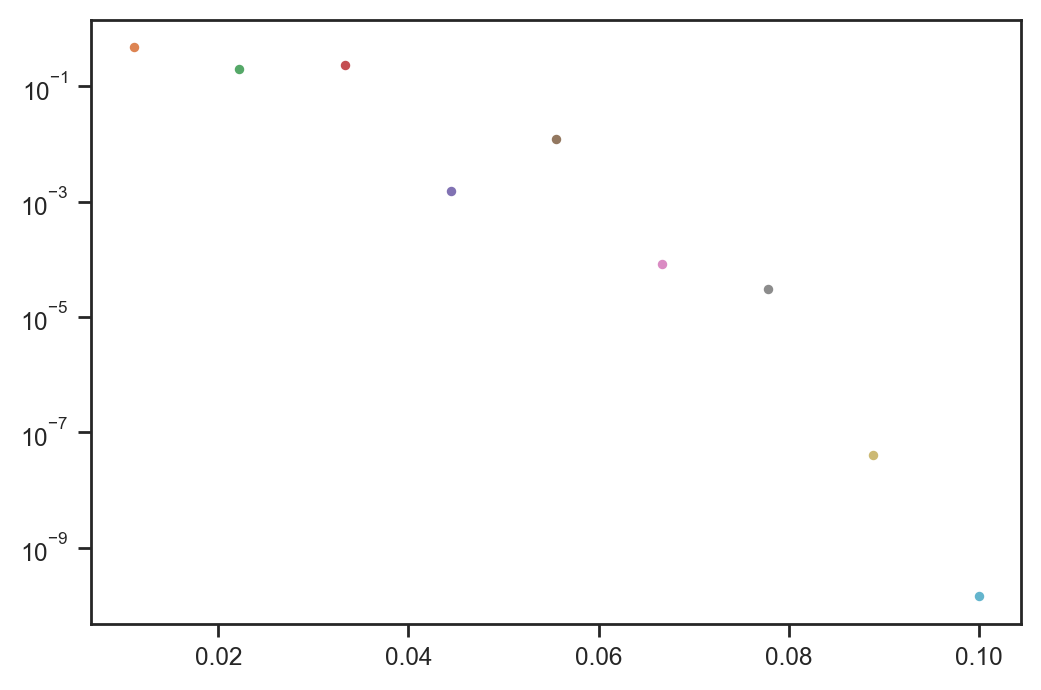

In [371]:
from scipy import stats

m = m_FP & m_ms & (cks['f18_P']<100)
fehmax = np.linspace(0,0.1,10)

for i in range(len(fehmax)):
    
    newm = m & (abs(cks['f18_[Fe/H]'])<fehmax[i])
    
    rho, pval = stats.spearmanr(cks['f18_logAiso'][newm], cks['f18_[Fe/H]'][newm])
    plt.plot(fehmax[i], pval, '.')
    print(len(cks['f18_logAiso'][newm]))
    
plt.semilogy()
plt.show()

# plt.figure(figsize=(6,4))

_binwidth = .1

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe

_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='blue', ecolor='blue', 
        label="all mask SNR .5",linewidth = 2)

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 
_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)


plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', 
        label="OG SNR .5",linewidth = 2)

plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.title('Normal sampling -- ')
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
plt.show()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


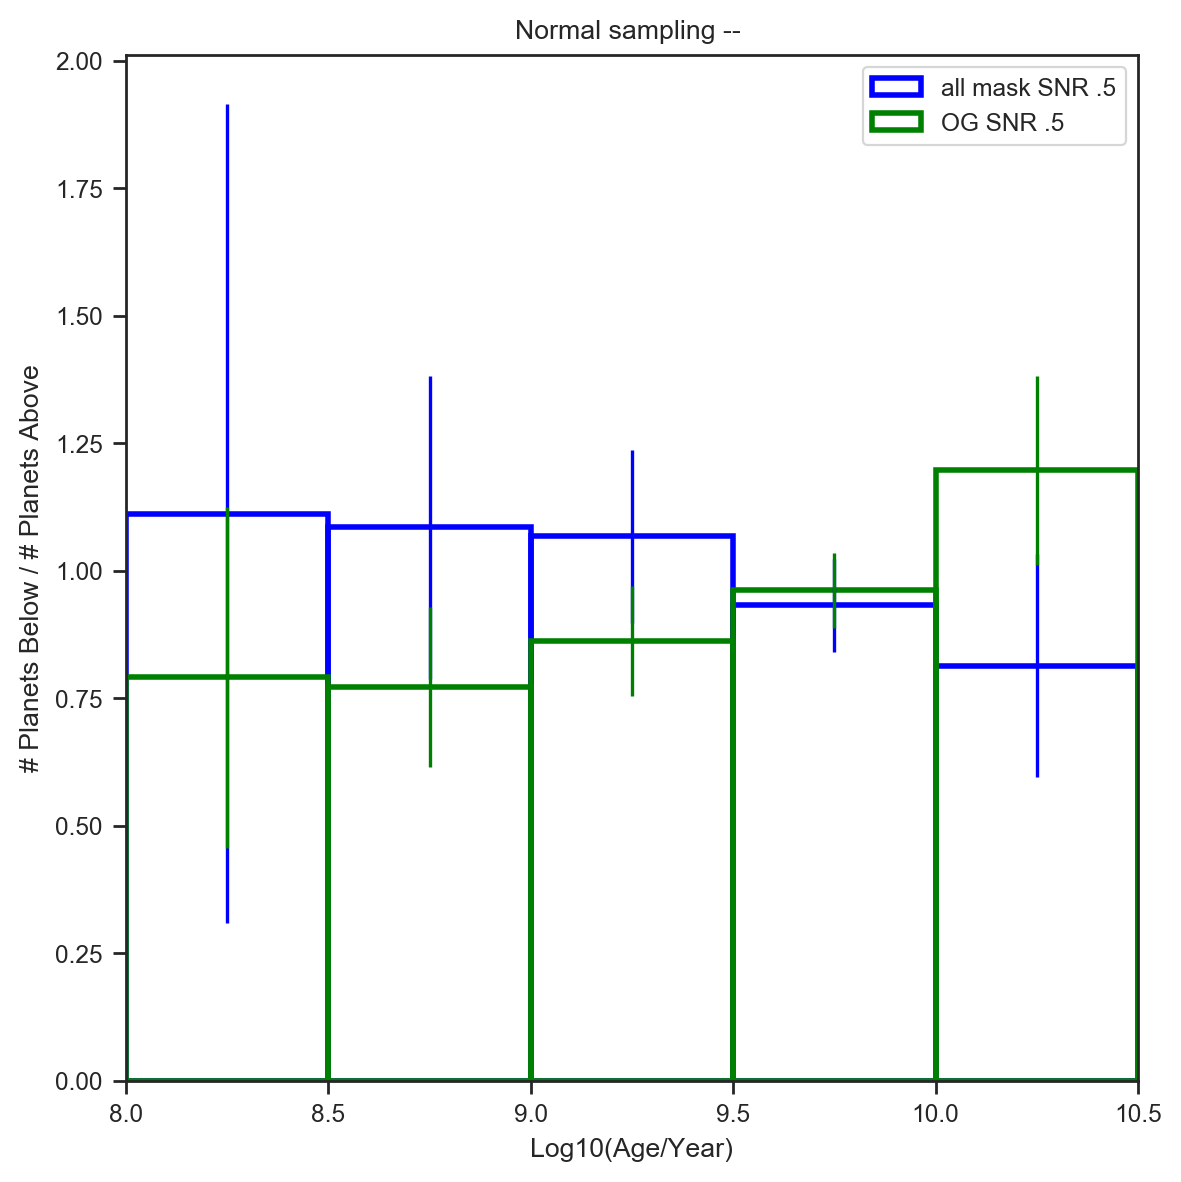

In [53]:
plt.figure(figsize=(6,4))

_binwidth = .5

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe

_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='blue', ecolor='blue', 
        label="all mask SNR .5",linewidth = 2)

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 
_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)


plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', 
        label="OG SNR .5",linewidth = 2)

plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.title('Normal sampling -- ')
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
plt.show()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


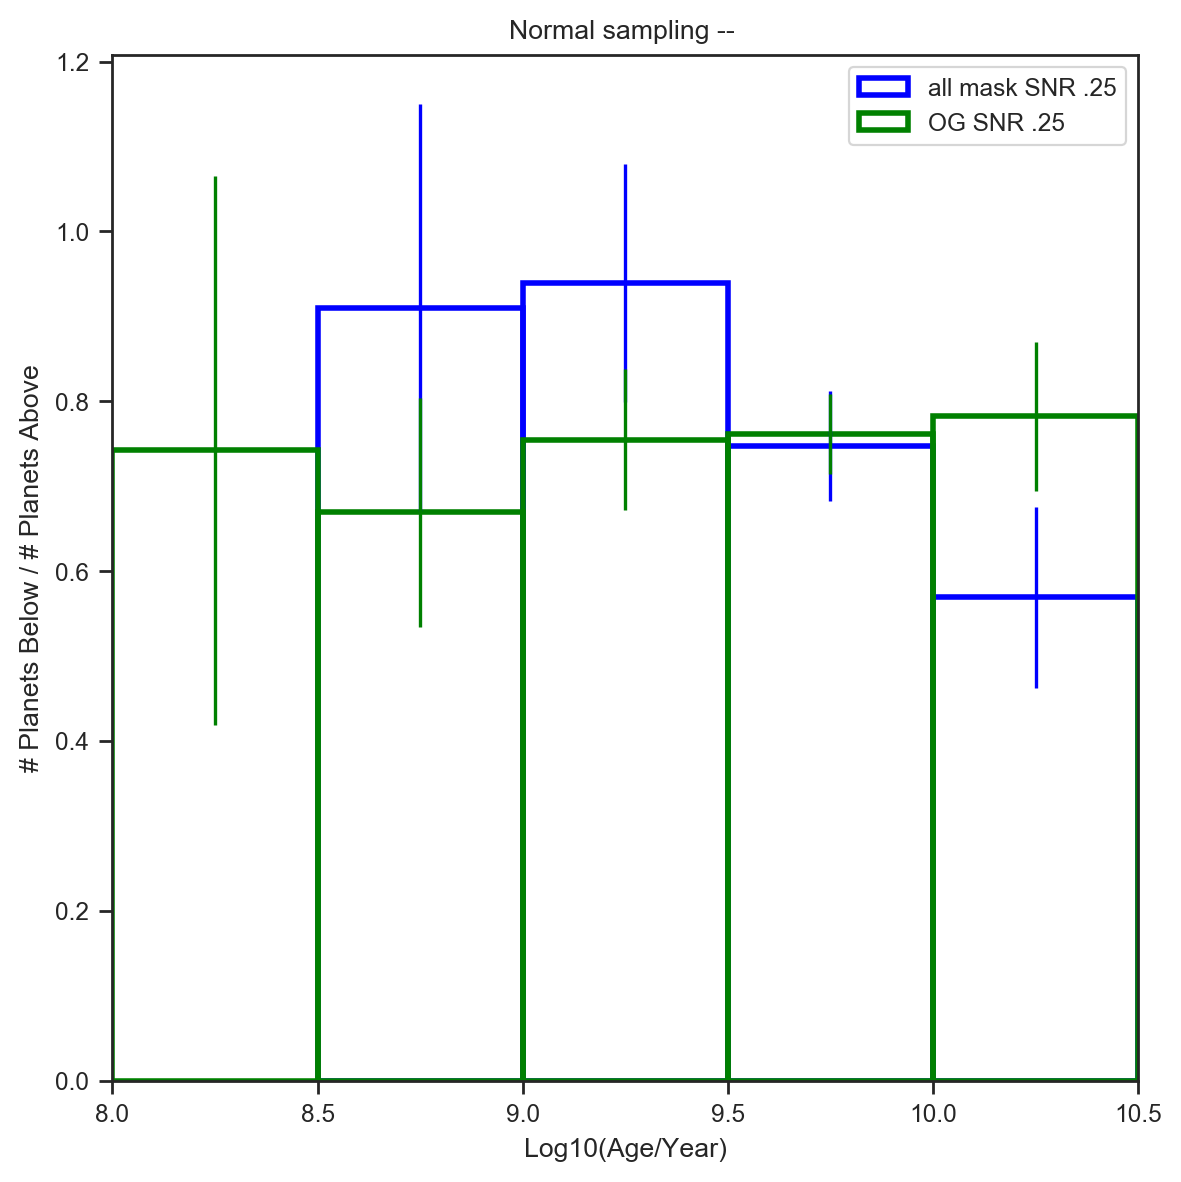

In [54]:
plt.figure(figsize=(6,4))

_binwidth = .5

m = m_multi & m_P & m_snr25 & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe

_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='blue', ecolor='blue', 
        label="all mask SNR .25",linewidth = 2)

m = m_multi & m_P & m_snr25 & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 
_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)


plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', 
        label="OG SNR .25",linewidth = 2)

plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.title('Normal sampling -- ')
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
plt.show()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


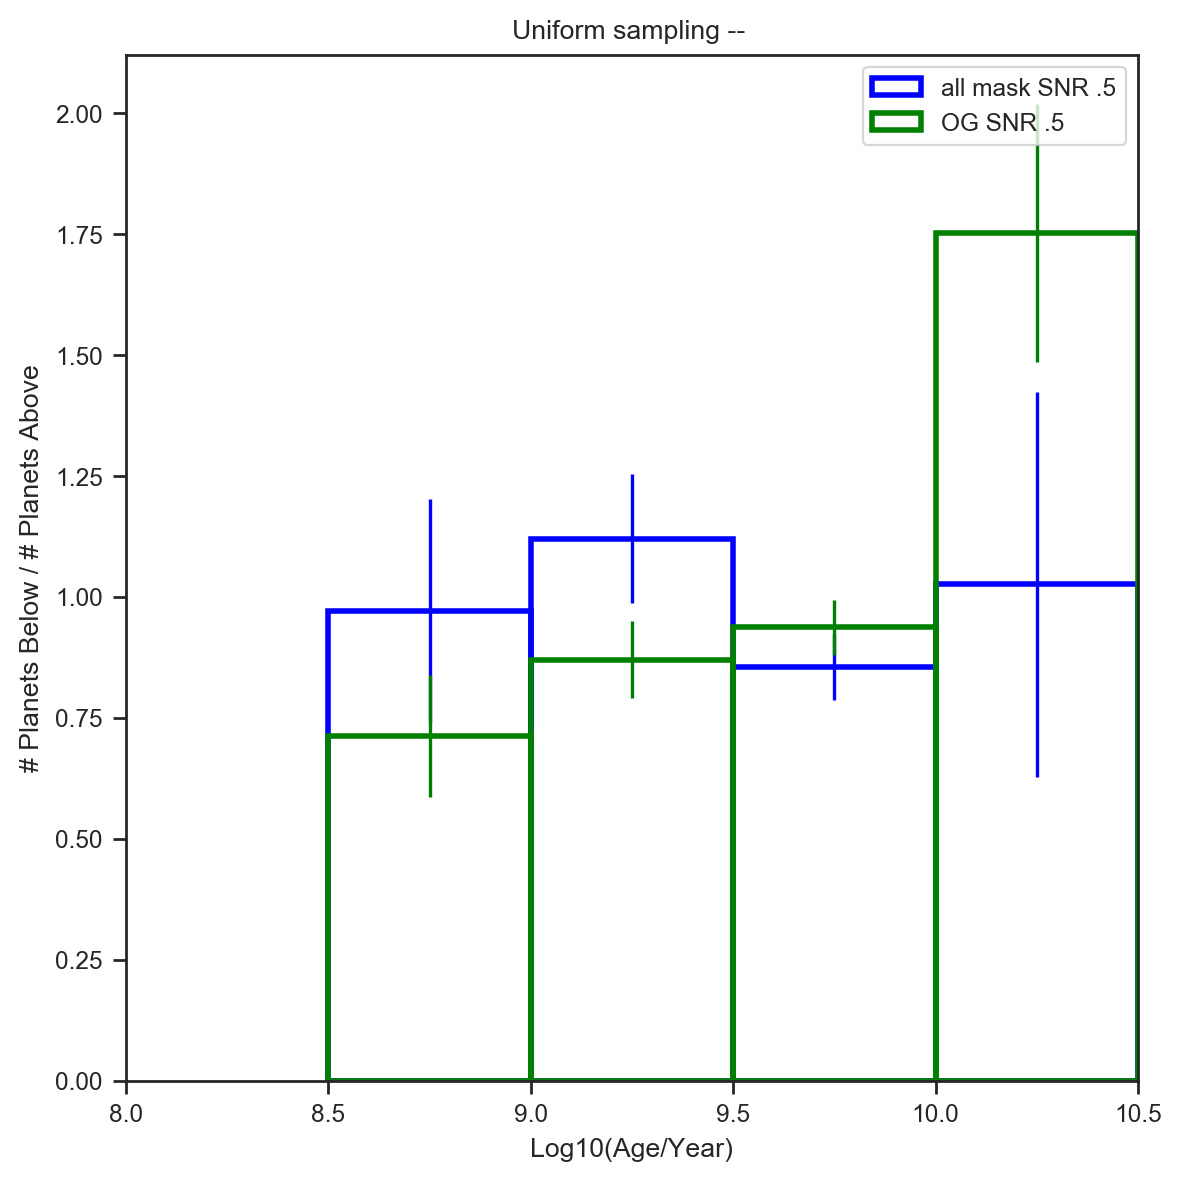

In [55]:
plt.figure(figsize=(6,4))

_binwidth = .5

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe

_ratio, bin_centers, _bin_edges = uniform_sampling(cks, m, _binwidth=_binwidth)
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='blue', ecolor='blue', 
        label="all mask SNR .5",linewidth = 2)

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 
_ratio, bin_centers, _bin_edges = uniform_sampling(cks, m, _binwidth=_binwidth)


plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', 
        label="OG SNR .5",linewidth = 2)

plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.title('Uniform sampling -- ')
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
plt.show()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


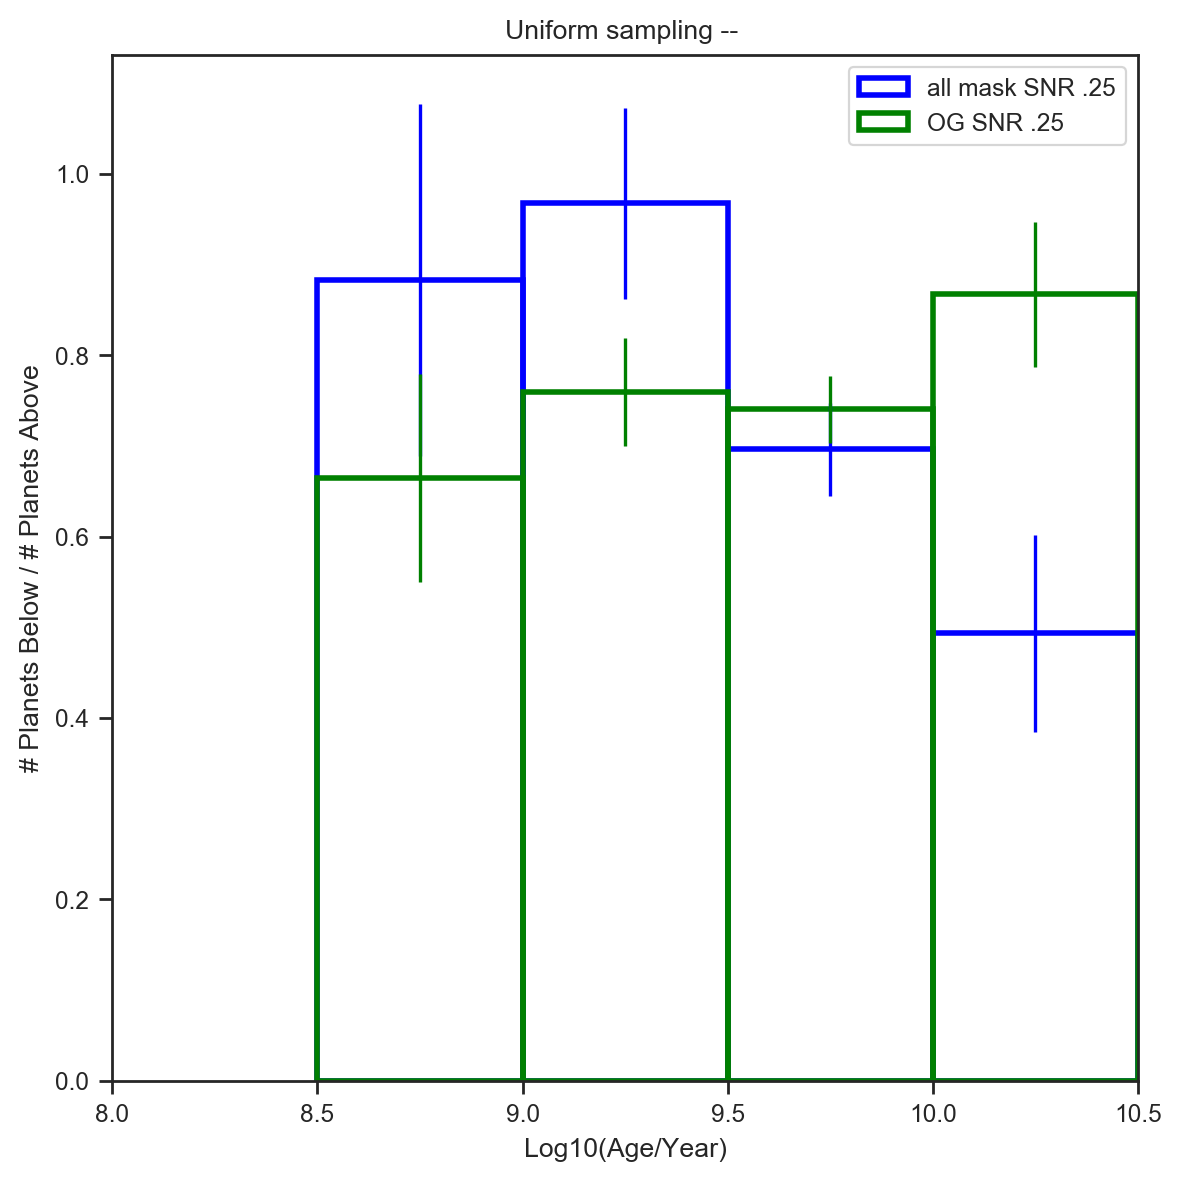

In [56]:
plt.figure(figsize=(6,4))

_binwidth = .5

m = m_multi & m_P & m_snr25 & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe

_ratio, bin_centers, _bin_edges = uniform_sampling(cks, m, _binwidth=_binwidth)
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='blue', ecolor='blue', 
        label="all mask SNR .25",linewidth = 2)

m = m_multi & m_P & m_snr25 & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 
_ratio, bin_centers, _bin_edges = uniform_sampling(cks, m, _binwidth=_binwidth)


plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', 
        label="OG SNR .25",linewidth = 2)

plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.title('Uniform sampling -- ')
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
plt.show()

In [352]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

array([[0, 1],
       [1, 0],
       [2, 1],
       [3, 4],
       [4, 3],
       [5, 4]])

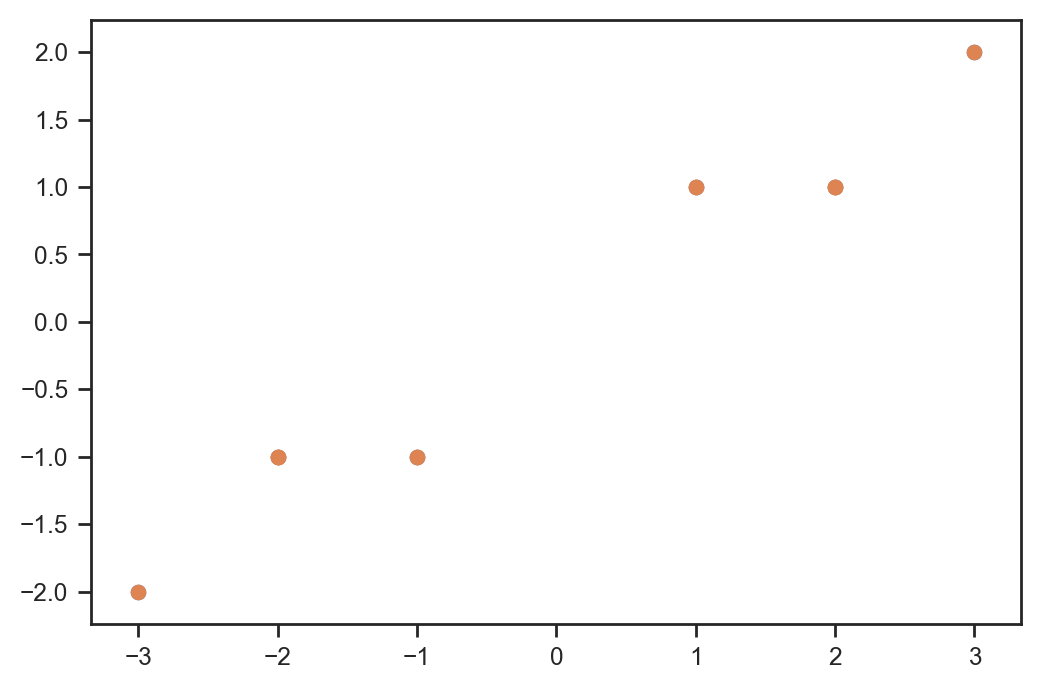

In [354]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[:,0][indices], X[:,1][indices])


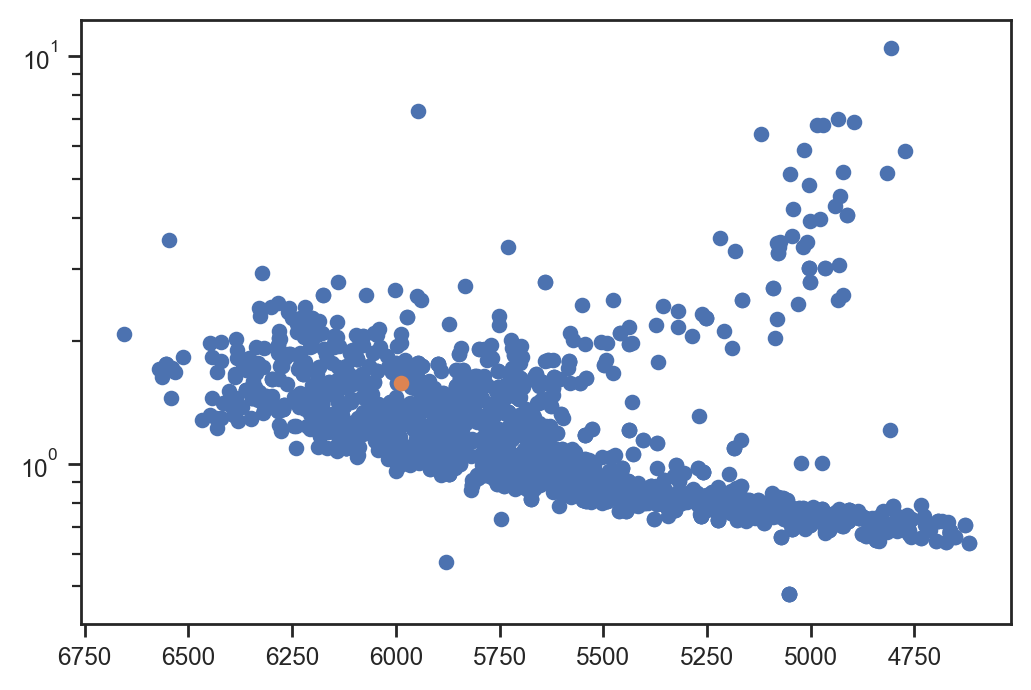

In [359]:
idx = np.random.choice(len(cks))

plt.scatter(cks['f18_Teff'], cks['f18_R'])
plt.scatter(cks['f18_Teff'][idx], cks['f18_R'][idx])
plt.gca().invert_xaxis()
plt.semilogy()
plt.show()

In [ ]:
m = m_FP & m_ms &\
    (cks['f18_P']<60) &\
    (cks['single_transit_snr']>0.4) &\
    (abs(cks['f18_[Fe/H]'])<0.2)# &\